# Text Classification

## Problem Statement
Scrape a corpus of news articles from a set of web pages, pre-process the corpus, and evaluate the performance of automated classification of these articles in a supervised learning context.

### Pre-requisites

### <font color='red'>News Archive:</font>

- A News Archive Wesite has been used to retrieve web pages. 
- <b>URL</b>: https://news-articles.herokuapp.com/archive/index.html

### <font color='red'>Pre Installations:</font> 

- pip install nltk
- pip install seaborn
- python -m pip install wordcloud-1.4.1-cp36-cp36m-win_amd64.whl <br> wheel file required for installing wordcloud(file provided), version may differ for different machines

### <font color='red'> Import Librabies required</font>

In [1]:
from IPython.display import display
%matplotlib inline

from pandas.io.json import json_normalize
import urllib.request
import json
import time
import os

import numpy as np
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Part 1 - Data Collection

### <font color='red'>1.1. URL Identification :</font>
   
The articles and their labels are collected in two steps:
- <b>Step 1:</b> Parse the index page to get list URLs for Monthly Data.
- <b>Step 2:</b> Parse the URL for Month page to get the list of articles and their category labels.

### <font color='blue'>Creating Classes to Retrieve Data:</font> 

#### <u>Class 1: NewsArchive</u>  -  News Archive Class to get data from URL

##### (Custom Class Used Later)

In [2]:
class NewsArchive:
    
    def __init__(self):
        '''
        To initialize News repository source URL 
        Create Required Data Folders to store articles and category information
        ''' 
        os.makedirs(os.getcwd() + "/data", exist_ok=True)            # Create ./data for storing articles and categories csv
        os.makedirs(os.getcwd() + "/data/articles", exist_ok=True)   # Create ./data/articles for storing articles
        self.__sourceUrl = "https://news-articles.herokuapp.com/archive/"  
    
    
    def request_html(self, page_name="index"):
        '''
        Parameters: page_name (url part of the page without ".html" and default as "index")
        Return: HTML
        --------
        To request data from a URL though HTTP request
        '''
        url = self.__sourceUrl + page_name+".html"
        try:
            response = urllib.request.urlopen(url)                     # Hit URL: url
            raw_html = response.read().decode()                        # Decode response                  
            return raw_html                                            # return raw html
        except Exception as h:
            print("Cannot find data at given URL\nError:"+str(h))      
            return ""                                                   

#### <u>Class 2: ParseData</u>  -  Parse Data Class to parse HTML pages

##### (Custom Class Used Later)

In [3]:
from bs4 import BeautifulSoup

class ParseData:

    def parse_index_page(self, html):
        '''
        Parameters: html content
        Return: Dictionary with month names and corrosponding urls
        --------
        Method to parse index html content to get URLs for monthly data URLs
        '''
        parsed_html = BeautifulSoup(html,"html.parser")

        month_dict={}
        div = parsed_html.body.find_all("div", {"class":"main"})
        for ul in div:
            for li in ul.find_all("li"):
                for a in li.find_all('a'):
                    month_dict[a.string] = a['href'].replace(".html","")

        return month_dict

    
    def parse_month_pages(self, html, month):    
        '''
        Parameters: html content, month name
        Return: Acticles list
        --------
        Method to parse URL for Monthly List of articles content to get articles data
        '''
        parsed_html = BeautifulSoup(html,"html.parser")
        
        article_list=[]
        div = parsed_html.body.find_all("div", {"class":"main"})
        for table in div:
            for tr in table.find_all("tr"):
                article_dict={}
                for td in tr.find_all('td', {"class":"category"}):
                    article_dict['category'] = td.string.replace(u'\xa0', u'')
                for td in tr.find_all('td', {"class":"title"}):    
                    for a in td.find_all('a'):
                        article_dict['id'] = a['href'].rstrip(".html")
                        article_dict['name'] = a.string
                    article_list.append(article_dict)
        return article_list    
    
    
    def parse_article(self,html):
        '''
        Parameters: html content
        Return: Parsed Acticle heading and paragraphs in String format
        --------
        Method to parse URL to get articles data
        '''
        parsed_html = BeautifulSoup(html,"html.parser")
        
        article_data = " "

        # Add heading to article data
        for heading in parsed_html.body.find_all("h2"):
            article_data = heading.getText() + article_data
            
        # To get text from p tags
        for data in parsed_html.body.find_all("p", attrs={'class': None}):
            text = data.getText()
            if[len(text)!=0]:
                article_data = article_data + text
        return article_data

Creating objects of the classes so that their functions for retreiving, storing and parsing the data can be applied 

In [4]:
# Creating objects of classes to use them further
newsArchive = NewsArchive()
parse = ParseData()

#### Parse main page and montly pages to get categories along with article id

Once we have all the data we can clean the dataframe by removing entries for which category labels or article URL are not present.(Articles which are no longer available)  

##### (Using the Custom Classes)

In [5]:
# First Level Parsing:- Index Page    
indexHTML = newsArchive.request_html()

# Second Level Parsing:- Monthly Pages
month_data = parse.parse_index_page(indexHTML)

# Creating categories-articles dataframe
df = pd.DataFrame([])
for key, value in month_data.items():
    html = newsArchive.request_html(value)
    month_data = parse.parse_month_pages(html, key)
    df = df.append(pd.read_json(json.dumps(month_data)))

df.reset_index(drop=True, inplace=True)    

In [6]:
display(df[0:5])

,category,id,name
0,technology,article-jan-0418,21st-Century Sports: How Digital Technology Is...
1,business,article-jan-0027,Asian quake hits European shares
2,technology,article-jan-0631,BT offers free net phone calls
3,business,article-jan-2105,Barclays shares up on merger talk
4,sport,article-jan-3300,Barkley fit for match in Ireland


#### Clean Category Articles Data

Check how many records in category dataframe are null and remove those records

In [7]:
# Find if any Null values in the records
print(df.isnull().any())

# Check number of records that are null in the dataset
print("\nTotal Null Valued Records: " + str(df.isnull().T.any().T.sum()))
print("\nNumber of records with N/A or NaN Values:", len(df))
df = df.dropna() 
print("\nNumber of records with clean values:", len(df))

category    False
id           True
name         True
dtype: bool

Total Null Valued Records: 53

Number of records with N/A or NaN Values: 1461

Number of records with clean values: 1408


#### Once the dataframe for category and articles is clean, it can be used further to download articles

In [8]:
df.reset_index(drop=True, inplace=True)  
display(df[-5:])

,category,id,name
1403,sport,article-dec-2238,Woodward eyes Brennan for Lions
1404,business,article-dec-2334,WorldCom trial starts in New York
1405,business,article-dec-2095,Yukos accused of lying to court
1406,business,article-dec-1351,Yukos drops banks from court bid
1407,sport,article-dec-0068,Zambia confident and cautious


### <font id="api-name" color='red'>1.2. Retrieve and Store Articles:</font> 

Retrieve all web pages corresponding to these article URLs. From the web pages, extract the main body text containing the content of each news article. Save the body of each article as plain text

#### Save all the available articles in a folder using the custom function to get article id from dataframe, parse html and save it in a location

In [9]:
def store_articles(row):
    '''
    Parameters: A dataframe row with structure (category, id, name)
    --------
    Save the article in /data/articles/ folder (using the id from dataframe row) 
    '''
    html = newsArchive.request_html(row['id'])
    article = parse.parse_article(html)
    # Write article to file 
    # exception handled if file locked by some other operation or could not write to file
    try:
        filename = os.getcwd() + "/data/articles/" + row['id'] + ".txt"            
        # open the file in write mode
        f = open(filename, "w",encoding='utf-8')
        f.write(article)
        f.close()
    except Exception as h:
        print("Cannot write to file\n" + row['id'] +" \nError:"+str(h))

In [10]:
_ = df.apply(store_articles, axis=1)

In [11]:
files = os.listdir(os.getcwd() + "/data/articles/")
print("Samples Files in the directory ./data/articles/")
display(files[:5])
print("Total Files saved:", len(files))

Samples Files in the directory ./data/articles/


['article-apr-0028.txt',
 'article-apr-0039.txt',
 'article-apr-0042.txt',
 'article-apr-0061.txt',
 'article-apr-0134.txt']

Total Files saved: 1408


### <font id="api-name" color='red'>1.3. Retrieve and Save the category labels/targets for all articles in a separate file</font>

#### We also need to save the target classes for each record in numrical form. 
##### (Factorizing Category Labels)

In [12]:
# Assign numerical values to categories and save as target corrosponding to every article
category_labels = pd.Series(df.category)

target, labels = pd.factorize(category_labels)

df['target'] = target

display(df[0:5])

# Factored List will be used as target class values
print(target)

# Labels Indexes will be used later to decipher the target name
print(labels)

,category,id,name,target
0,technology,article-jan-0418,21st-Century Sports: How Digital Technology Is...,0
1,business,article-jan-0027,Asian quake hits European shares,1
2,technology,article-jan-0631,BT offers free net phone calls,0
3,business,article-jan-2105,Barclays shares up on merger talk,1
4,sport,article-jan-3300,Barkley fit for match in Ireland,2


[0 1 0 ..., 1 1 2]
Index(['technology', 'business', 'sport'], dtype='object')


#### Save the dataframe will numrical/factorized class labels in a csv file

In [ ]:
# Save Cleaned data for articles names and their Categories 
# exception handled if file locked by some other operation or could not write to file

try:
    filename = os.getcwd() + "/data/category.csv"
    df.to_csv(filename, sep=',', encoding='utf-8')
    print("Write to CSV:\n" + filename)
except Exception as h:
    print("Cannot write to file \nError:" + str(h))
    

## 2. Part 2 - Text Classification

### <font color="red">2.1. Loading Corpus in notebook</font>

#### Check if all the articles have category labels

<br><i><b>Kindly Note:</b> The dataframe for categories-arcticles was cleaned earlier but this step is just to ensure that correct records will be used for processing the articles.</i>

In [14]:
# Check number of records that are null in the dataset
print("\nTotal Null Valued Records: " + str(df.isnull().T.any().T.sum()))


Total Null Valued Records: 0


#### Get the list of articles from the dataframe

In [15]:
article_ids = df.id.tolist()
article_ids[0:5]

['article-jan-0418',
 'article-jan-0027',
 'article-jan-0631',
 'article-jan-2105',
 'article-jan-3300']

#### Load the set of raw documents using list of articles (Reading already parsed and saved articles)

In [16]:
documents = []

for article_id in article_ids:
    path = os.getcwd() + "/data/articles/" + article_id + ".txt" 
    rawtext = open(path, "r", encoding = 'utf-8').read()
    documents.append(rawtext)

print("Total text documents loaded: %d" % len(documents))

Total text documents loaded: 1408


#### Sample Details for 1 Article

In [17]:
print("Article ID- %s " % article_ids[0])
print("Target Class- %s " % target[0])
print("Target Class Label- %s " % labels[target[0]])
print("Raw Document- %s " % documents[0])

Article ID- article-jan-0418 
Target Class- 0 
Target Class Label- technology 
Raw Document- 21st-Century Sports: How Digital Technology Is Changing the Face Of The Sporting Industry The sporting industry has come a long way since the ‘60s. It has carved out for itself a niche with its roots so deep that I cannot fathom the sports industry showing any sign of decline any time soon - or later.The reason can be found in this seemingly subtle difference - other industries have customers; the sporting industry has fans. Vivek Ranadivé, leader of the ownership group of the NBA’s Sacramento Kings, explained it beautifully, “Fans will paint their face purple, fans will evangelize. ... Every other CEO in every business is dying to be in our position — they’re dying to have fans.“While fan passion alone could almost certainly keep the industry going, leagues and sporting franchises have decided not to rest on their laurels. The last few years have seen the steady introduction of technology into

### <font color="red">2.2. From the raw documents, create a document-term matrix, using appropriate text pre-processing and term weight</font>

### 2.2.1. Pre-Processing

The raw documents are splitted to form tokens. These tokens will be cleaned and then will be used for analysis. Tokens are cleaned by following Standard Pre-processing Steps:

1. Tokenization
2. Normalisation/ Case Conversion
3. Stop words Filtering
4. Stemming/ Lemmatisation 

#### <u>Step 1:</u> Tokenization + Normalization (Lower Case Coversion)

Tokenize and normalize data using the custom class object

In [18]:
def tokenize_normalize(documents):
    '''
    Parameters: documents (List of documents)
    Return: normalized tokens list for every document
    --------
    To convert the words in the documents to lower case and tokenize them using scikit-learn
    '''
    tokenize = CountVectorizer().build_tokenizer()
    tokens = []
    for article in documents:
        tokens.append(tokenize(article.lower()))       # Normalization(lowercase conversion) and Tokenization   
    return tokens

In [19]:
tokens = tokenize_normalize(documents)

# Sample Normalized Tokens and length of tokens for an article
print("Sample Normalized Tokens for Article with ID: '%s' \n" % article_ids[0])
print(tokens[0])
print("\nLength of Tokens: %d\n" % len(tokens[0]))

Sample Normalized Tokens for Article with ID: 'article-jan-0418' 

['21st', 'century', 'sports', 'how', 'digital', 'technology', 'is', 'changing', 'the', 'face', 'of', 'the', 'sporting', 'industry', 'the', 'sporting', 'industry', 'has', 'come', 'long', 'way', 'since', 'the', '60s', 'it', 'has', 'carved', 'out', 'for', 'itself', 'niche', 'with', 'its', 'roots', 'so', 'deep', 'that', 'cannot', 'fathom', 'the', 'sports', 'industry', 'showing', 'any', 'sign', 'of', 'decline', 'any', 'time', 'soon', 'or', 'later', 'the', 'reason', 'can', 'be', 'found', 'in', 'this', 'seemingly', 'subtle', 'difference', 'other', 'industries', 'have', 'customers', 'the', 'sporting', 'industry', 'has', 'fans', 'vivek', 'ranadivé', 'leader', 'of', 'the', 'ownership', 'group', 'of', 'the', 'nba', 'sacramento', 'kings', 'explained', 'it', 'beautifully', 'fans', 'will', 'paint', 'their', 'face', 'purple', 'fans', 'will', 'evangelize', 'every', 'other', 'ceo', 'in', 'every', 'business', 'is', 'dying', 'to', 'be', '

#### <u>Step 2:</u> Stopwords Removal

Scikit-learn feature extract Stopwords list (frozenset)

In [20]:
# List of Stopwords that will be removed
stopwords = text.ENGLISH_STOP_WORDS
print("Stopwords List:")
print(stopwords)

Stopwords List:
frozenset({'less', 'first', 'itself', 'during', 'latterly', 'nowhere', 'though', 'he', 'anyone', 'our', 'anything', 'until', 'whereas', 'also', 'behind', 'while', 'thereupon', 'within', 'onto', 'found', 'me', 'once', 'put', 'herself', 'becoming', 'same', 'an', 'else', 'couldnt', 'those', 'others', 'us', 'please', 'top', 'former', 'back', 'but', 'go', 'between', 'keep', 'last', 'among', 'per', 'than', 'been', 'was', 'your', 'over', 'am', 'both', 'third', 'cant', 'other', 'thru', 'elsewhere', 'four', 'can', 'as', 'with', 'by', 'only', 'before', 'everywhere', 'whole', 'call', 'they', 'formerly', 'serious', 'nevertheless', 'thin', 'thus', 'none', 'almost', 'towards', 'six', 'whither', 'amoungst', 'whereby', 'are', 'if', 'myself', 'all', 'will', 'either', 'cry', 'she', 'un', 'sincere', 'somewhere', 'every', 'to', 'around', 'nor', 'already', 'eight', 'indeed', 'not', 'few', 'further', 'neither', 'or', 'perhaps', 'still', 'take', 'thence', 'twenty', 'that', 'forty', 'we', 'som

Filter out the above shown stopwords from the list of tokens for all the documents using custom class object

In [21]:
def filter_stopwords(tokens, stopwords):
    '''
    Parameters: tokens (List of tokens for every document), stopwords (List of stopwords)
    Return: stopwords filtered tokens list for every document
    --------
    To update the tokens list by filtering stopwords
    '''
    for i in range (0, len(tokens)):
        filtered_token = []
        for token in tokens[i]:
            if token not in stopwords:
                filtered_token.append(token)
        tokens[i] = filtered_token
    return tokens

In [22]:
# Filter out stopwords from the list of tokens for every document
tokens = filter_stopwords(tokens, stopwords)
print("Created %d filtered token lists" % len(tokens))

# Sample Filtered Tokens and length of tokens for an article
print("\nSample Filtered Tokens for Article with ID: '%s' \n" % article_ids[0])
print(tokens[0])
print("\nLength of Tokens: %d\n" % len(tokens[0]))

Created 1408 filtered token lists

Sample Filtered Tokens for Article with ID: 'article-jan-0418' 

['21st', 'century', 'sports', 'digital', 'technology', 'changing', 'face', 'sporting', 'industry', 'sporting', 'industry', 'come', 'long', 'way', '60s', 'carved', 'niche', 'roots', 'deep', 'fathom', 'sports', 'industry', 'showing', 'sign', 'decline', 'time', 'soon', 'later', 'reason', 'seemingly', 'subtle', 'difference', 'industries', 'customers', 'sporting', 'industry', 'fans', 'vivek', 'ranadivé', 'leader', 'ownership', 'group', 'nba', 'sacramento', 'kings', 'explained', 'beautifully', 'fans', 'paint', 'face', 'purple', 'fans', 'evangelize', 'ceo', 'business', 'dying', 'position', 'dying', 'fans', 'fan', 'passion', 'certainly', 'industry', 'going', 'leagues', 'sporting', 'franchises', 'decided', 'rest', 'laurels', 'years', 'seen', 'steady', 'introduction', 'technology', 'world', 'sports', 'amplifying', 'fans', 'appreciation', 'games', 'enhancing', 'athletes', 'public', 'profiles', 'inf

#### <u>Step 3:</u> Lemmatization 

Reduce tokens to their canonical form

<i><b>Kindly Note:</b> We are using WordNetLemmatization instead of standard English stemming algorithm (called the Porter Stemmer) beacuse Lemmatization preseves the words instead of trimming the last characters</i>

In [23]:
def lemmatizer(tokens):
    '''
    Parameters: tokens (List of tokens for every document)
    Return: lemmatized tokens list for every document
    --------
    Function for lemmatizing to reduce a term to its canonical form 
    WordNetLemmatizer from nltk used since scikit-learn does not support it
    '''
    lemmatizer = nltk.stem.WordNetLemmatizer()
    for i in range (0, len(tokens)):
        lemma_tokens = []
        for token in tokens[i]:
            lemma_tokens.append(lemmatizer.lemmatize(token))
        tokens[i] = lemma_tokens
    return tokens

In [24]:
# lemmatizing tokens for every document
tokens = lemmatizer(tokens)
print("Created %d Lemmatized token lists" % len(tokens))

# Sample Filtered Tokens and length of tokens for an article
print("\nSample Lemmatized Tokens for Article with ID: '%s' \n" % article_ids[0])
print(tokens[0])
print("\nLength of Tokens: %d\n" % len(tokens[0]))

Created 1408 Lemmatized token lists

Sample Lemmatized Tokens for Article with ID: 'article-jan-0418' 

['21st', 'century', 'sport', 'digital', 'technology', 'changing', 'face', 'sporting', 'industry', 'sporting', 'industry', 'come', 'long', 'way', '60', 'carved', 'niche', 'root', 'deep', 'fathom', 'sport', 'industry', 'showing', 'sign', 'decline', 'time', 'soon', 'later', 'reason', 'seemingly', 'subtle', 'difference', 'industry', 'customer', 'sporting', 'industry', 'fan', 'vivek', 'ranadivé', 'leader', 'ownership', 'group', 'nba', 'sacramento', 'king', 'explained', 'beautifully', 'fan', 'paint', 'face', 'purple', 'fan', 'evangelize', 'ceo', 'business', 'dying', 'position', 'dying', 'fan', 'fan', 'passion', 'certainly', 'industry', 'going', 'league', 'sporting', 'franchise', 'decided', 'rest', 'laurel', 'year', 'seen', 'steady', 'introduction', 'technology', 'world', 'sport', 'amplifying', 'fan', 'appreciation', 'game', 'enhancing', 'athlete', 'public', 'profile', 'informing', 'trainin

#### <u>Step 4:</u> Create Corpus of articles from the pre-processed Tokens

In [25]:
corpus = []
for articles in tokens:
    corpus.append(" ".join(articles))
    
# Sample Clean Article and number of articles in corpus
print("Sample clean acrticle for Article with ID: '%s' \n" % article_ids[0])
print(corpus[0])
print("\nNumber of Articles in Corpus: %d\n" % len(corpus))

Sample clean acrticle for Article with ID: 'article-jan-0418' 

21st century sport digital technology changing face sporting industry sporting industry come long way 60 carved niche root deep fathom sport industry showing sign decline time soon later reason seemingly subtle difference industry customer sporting industry fan vivek ranadivé leader ownership group nba sacramento king explained beautifully fan paint face purple fan evangelize ceo business dying position dying fan fan passion certainly industry going league sporting franchise decided rest laurel year seen steady introduction technology world sport amplifying fan appreciation game enhancing athlete public profile informing training method influencing contest waged digital technology particular helped create alternative source revenue game corporate sponsorship achieved capitalizing ardor customer base sorry fan base

Number of Articles in Corpus: 1408



### 2.2.2. Count Vector using (CountVectorizor)

#### Create count vector keeping minimum document frequnecy as 3

In [26]:
vectorizer = CountVectorizer(min_df = 3)
countVector = vectorizer.fit_transform(corpus)
print(countVector.shape)

(1408, 8763)


#### Number of Terms in Vocabulary

In [27]:
print("Number of terms: %d" % len(vectorizer.vocabulary_))

Number of terms: 8763


#### Some sample terms

In [28]:
print(list(vectorizer.vocabulary_.keys())[:40])

['21st', 'century', 'sport', 'digital', 'technology', 'changing', 'face', 'sporting', 'industry', 'come', 'long', 'way', '60', 'niche', 'root', 'deep', 'showing', 'sign', 'decline', 'time', 'soon', 'later', 'reason', 'seemingly', 'difference', 'customer', 'fan', 'leader', 'ownership', 'group', 'nba', 'king', 'explained', 'paint', 'ceo', 'business', 'dying', 'position', 'passion', 'certainly']


#### Verify if stopwords are removed

In [29]:
"and" in vectorizer.get_feature_names()

False

### 2.2.3. Term Weighing using (TfidfVectorizer)

Instead of doing everything separately, Scikit-learn provides the capability to perform everything in a single step where we can also adjust parameters. However, we can also create TF-IDF Matrix using Count Vector generated earlier. This command will directly create the weighted term document matrix.<br><br>
Parameters Used:
1. Stopwords = English
2. Minimum Document Frequency = 3
3. Tokenizer = lemma_tonkenizer (Custom NLTK based function)

#### Function for lemmatizing data using NLTK WordNetLemmatizer

In [30]:
def lemma_tokenizer(text):
    '''
    Function for lemmatizing to reduce a term to its canonical form 
    '''
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append( lemmatizer.lemmatize(token) )
    return lemma_tokens

#### Create TF-IDF Matrix using scikit-learn

In [31]:
tfidf = TfidfVectorizer(stop_words="english",min_df = 3,ngram_range=(1, 2),tokenizer=lemma_tokenizer)
X = tfidf.fit_transform(documents)
print(X.shape)

(1408, 20653)


#### Verify if stopwords are removed

In [32]:
"and" in tfidf.get_feature_names()

False

In [33]:
vocab = tfidf.vocabulary_
print("Number of Terms: %d" % len(vocab))

Number of Terms: 20653


#### Total Vocabulary Terms

In [34]:
terms = tfidf.get_feature_names()
print("Distinct Vocabulary Terms: %d" % len(terms))

Distinct Vocabulary Terms: 20653


#### Create a Document-Term Matrix
##### (Bag of Words)

In [35]:
document_term_matrix = pd.DataFrame(X.toarray(), columns = tfidf.get_feature_names(), index = article_ids).T
print("Sample Bag of Words Model (with Term Weights):")
document_term_matrix[-10:]

Sample Bag of Words Model (with Term Weights):


,article-jan-0418,article-jan-0027,article-jan-0631,article-jan-2105,article-jan-3300,article-jan-4187,article-jan-1974,article-jan-3666,article-jan-2629,article-jan-2415,...,article-dec-4918,article-dec-2759,article-dec-4347,article-dec-3179,article-dec-1456,article-dec-2238,article-dec-2334,article-dec-2095,article-dec-1351,article-dec-0068
zinedine,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zinedine zidane,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zip,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zola,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zombie,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zombie bot,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zone,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zoom,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zurich,0.0,0.046698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zurich premiership,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.2.4. Summarizing Corpus

#### a) Top ten terms in the corpus

In [36]:
df2=document_term_matrix.T.sum().sort_values(ascending=False)
df2[:10]

said      47.306146
wa        42.241611
ha        39.364000
year      31.225139
game      30.747373
u         25.965329
mr        21.802977
people    21.529860
player    21.063421
new       21.019829
dtype: float64

#### b) Top Correlated Terms for each Category
####     ( Chi<sup>2</sup> for finding correlated terms using tfidf vectorizer )

In [37]:
category_id_df = df[['category', 'target']].drop_duplicates().sort_values('target')
category_to_id = dict(category_id_df.values)
category_to_id

{'business': 1, 'sport': 2, 'technology': 0}

In [38]:
# Using the scikit-learn chi2 function to find features for chi-square category-wise and finding most correlated terms
class_labels = df.target
N = 2
Chi_df = X
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(Chi_df.toarray(), class_labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("Category: '%s'" % category)
    print()
    print("1. Most correlated unigrams:\n . {}".format('\n . '.join(unigrams[-N:])))
    print()
    print("2. Most correlated bigrams:\n . {}".format('\n . '.join(bigrams[-N:])))
    print("-----------------------\n")

Category: 'business'

1. Most correlated unigrams:
 . bank
 . economy

2. Most correlated bigrams:
 . oil price
 . economic growth
-----------------------

Category: 'sport'

1. Most correlated unigrams:
 . cup
 . england

2. Most correlated bigrams:
 . world cup
 . year old
-----------------------

Category: 'technology'

1. Most correlated unigrams:
 . user
 . mobile

2. Most correlated bigrams:
 . said mr
 . mobile phone
-----------------------



#### c) Category-wise Terms Count

The idea is to concatenate all the documents belonging to one category and then create a word cloud for the words belonging to one category. The word count is shown later in the visualizations section

In [39]:
category_concated_documents = []

for i in range(0,len(labels)):
    indexes = list(df.loc[df['category'] == labels[i]].index)
    concat_doc = ""
    for j in indexes:
        concat_doc = concat_doc + " " + corpus[j]
    category_concated_documents.append(concat_doc)
    print("Number of words in Category "+ labels[i] +" are: "+ str(len(category_concated_documents[i])))

Number of words in Category technology are: 743045
Number of words in Category business are: 655470
Number of words in Category sport are: 660271


#### d) Cosine Similarity

The articles belonging to different categories differ from each other and it is also possibl that one or more catgories are highly related. For finding similarity between categories we can use cosine similarity.
<br>
<b>*Cosine similarity*:</b> Most common approach for measuring similarity between two documents in a bag-of-words representation is to look at the cosine of the angle between their corresponding two term vectors. The motivation is that vectors for documents containing similar terms will point in the same direction in the m-dimensional vector space.

In [40]:
category_vectorizer = TfidfVectorizer(stop_words="english",min_df = 3,ngram_range=(1, 2),tokenizer=lemma_tokenizer)
category_vector = category_vectorizer.fit_transform(category_concated_documents)
print(category_vector.shape)

(3, 4085)


In [41]:
cosine_matrix = pd.DataFrame([])
# Measure the cosine similarity between the first document vector and all of the others
print("Cosine Similarity Scores:")
for i in range(0,len(labels)):
    temp_scores = []
    for row in range(0,len(labels)):
        cos = cosine_similarity( category_vector[i], category_vector[row] )
        temp_scores.append(cos[0][0])
    cosine_matrix[labels[i]] = temp_scores

cosine_matrix[""] = labels    
cosine_matrix.set_index("", inplace=True)
display(cosine_matrix)

Cosine Similarity Scores:


,technology,business,sport
,,,
technology,1.000000,0.670587,0.577151
business,0.670587,1.000000,0.518109
sport,0.577151,0.518109,1.000000


### <font color="red">2.3. Build two multi-class classification models using two different classifiers</font>


Classification Algorithms Used:

- Naive Bayes Algorithm
- Linear SVC Algorithm

In [42]:
# Import Libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#### Splitting Data to get Test and Training Data 

##### (Using a split size of 0.3 or 30% as Test Set and 70% as Training Set)

In [43]:
X.shape

(1408, 20653)

In [44]:
target

array([0, 1, 0, ..., 1, 1, 2], dtype=int64)

In [45]:
dataset_train, dataset_test, target_train, target_test = train_test_split(X, target, test_size=0.3)
print("Training set size is %d" % dataset_train.shape[0] )
print("Test set size is %d" % dataset_test.shape[0] )

Training set size is 985
Test set size is 423


Variables for Measuring Running Times of Algorithms:

In [46]:
model_names = ["MultinomialNB", "LinearSVC"]
models = []
train_times = []
tuned_models = []
tuned_train_times = []

### 2.3.1. Model Training (Default parameters)

#### <font color="red">a) Algorithm 1: *Naive Bayes Classification*</font>
##### <font color="brown">Multinomial Naive Bayes - Train Model using default parameters</font>

In [47]:
startTime = time.time()

model = MultinomialNB()
model.fit(dataset_train, target_train)

# Find out elapsed time in finding training the model using Naive Bayes Classifier
elapsed_time = time.time() - startTime
train_times.append(elapsed_time)

models.append(model)
print(models[0])
print("Time Required to Train the model: " + str(train_times[0]))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Time Required to Train the model: 0.01698923110961914


#### <font color="red">b) Algorithm 2: *LinearSVC Classification*</font>
##### <font color="brown">Support Vector Machine (LinearSVC) - Train Model using default parameters</font>

In [48]:
startTime = time.time()

model = LinearSVC()
model.fit(dataset_train, target_train)

# Find out elapsed time in finding training the model using LinearSVC (SVM with Linear Kernel) Classifier
elapsed_time = time.time() - startTime
train_times.append(elapsed_time)

models.append(model)
print(models[1])
print("Time Required to Train the model: " + str(train_times[1]))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Time Required to Train the model: 0.1578991413116455


### 2.3.2. Model Training (With Parameter Tuning)

The models are at a risk of overfitting since the parameters are selected randomly. The k fold cross-validation strategy alongwith parameter selection while training the model can ensure that the model does not get biased towards the data set. Using GridSearchCV for the two algorithms along with 5 fold cross-validation to make tuned models.

#### <font color="red">a) Algorithm 1: *Naive Bayes Classification*</font>
##### <font color="brown">Multinomial Naive Bayes - Tune Model choosing best among ($alpha=1, 0.1, 0.01, 0.001, 0.0001, 0.00001$)</font>
##### (where alpha is a hyperparameter which controls the form of model)

The smoothing priors &alpha; &ge; 0 accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting &alpha; = 1 is called Laplace smoothing, while &alpha; < 1 is called Lidstone smoothing.<sup>[6]</sup> 

In [49]:
startTime = time.time()

model = MultinomialNB()
param_grid = [{'alpha':[1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}]

grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(dataset_train, target_train)

# Find out elapsed time in finding training the model using Naive Bayes Classifier
elapsed_time = time.time() - startTime
tuned_train_times.append(elapsed_time)

tuned_models.append(grid)
print(tuned_models[0])
print("Time Required to Train the model: " + str(tuned_train_times[0]))

GridSearchCV(cv=5, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
Time Required to Train the model: 0.7665276527404785


#### <font color="red">b) Algorithm 2: *LinearSVC Classification*</font>
##### <font color="brown">Support Vector Machine (LinearSVC) Tune Model choosing best among ($C=1, 10, 100, 1000$)</font>

The pipeline module is used here for feature selection criteria and then classification. The SVM optimization is set using C parameter. It decides how much to avoid misclassifying each training example. <i>"For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points. For very tiny values of C, you should get misclassified examples, often even if your training data is linearly separable."</i><sup>[11]</sup>

In [50]:
startTime = time.time()

model = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])

C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'classification__C': C_OPTIONS
    },
    {
        'classification__C': C_OPTIONS
    },
]

grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(dataset_train, target_train)

# Find out elapsed time in finding training the model using Naive Bayes Classifier
elapsed_time = time.time() - startTime
tuned_train_times.append(elapsed_time)

tuned_models.append(grid)
print(tuned_models[1])
print("Time Required to Train the model: " + str(tuned_train_times[1]))

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0),
        prefit=False, thresho...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'classification__C': [1, 10, 100, 1000]}, {'classification__C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
Time Required to Train the model: 14.411129474639893


### <font color="red">2.4. Comparing the predictions of the two classification models using an appropriate evaluation strategy</font>

The following parameters will be used to evaluate the perfromace of the two classification models:
1. Accuracy of Models for Simple Train/Test Splits
    - Simple Model Accuracies
    - Tuned Model Accuracies
2. Evaluation Measures
2. Cross Validation
3. Visualizations

### 2.4.1 Accuracy of Models for Simple Train/Test Splits

Using the unseen test data to evaluate the models accuracy.

#### <font color="red">a) Models with Default Parameters</font>

#### Predict Values using two models  (Check if model is tranined and working)

In [51]:
# Predicting values using the two Algorithm

test_times = []
predictions = []
for i in range(0,len(model_names)):
    startTime = time.time()
    predictions.append(models[i].predict(dataset_test))

    # Find out elapsed time in testing the model using KNN Classifier
    elapsed_time = time.time() - startTime
    test_times.append(elapsed_time)

    print("Time Required to test "+ model_names[i] +" :" + str(test_times[i]))
    print("\nSample Predicted Classes Vs Actual Classes:")
    print("Target \t\t",target_test[:15])
    print("Predictions\t",predictions[i][:15])
    print()

Time Required to test MultinomialNB :0.003995418548583984

Sample Predicted Classes Vs Actual Classes:
Target 		 [1 1 1 1 0 2 1 0 0 1 0 2 1 1 2]
Predictions	 [1 1 1 1 0 2 1 0 0 1 0 2 1 1 2]

Time Required to test LinearSVC :0.003998994827270508

Sample Predicted Classes Vs Actual Classes:
Target 		 [1 1 1 1 0 2 1 0 0 1 0 2 1 1 2]
Predictions	 [1 1 1 1 0 2 1 0 0 1 0 2 1 1 2]



#### Accuracy Scores for the two algorithms with default parameters

Overall accuracy score for the predictions is the fraction of correct predictions. AccuracyScore Function returns a value between 0 (completely wrong) and 1 (predictions are 100% accurate):

In [52]:
#Accuracies for different classifiers
accuracy_scores = []
for m in range(0,len(model_names)):
    accuracy_scores.append(accuracy_score(target_test, predictions[m]))
    print("Accuracy of "+model_names[m]+" Classifier =\t%.4f" % accuracy_scores[m])
    print()

Accuracy of MultinomialNB Classifier =	0.9787

Accuracy of LinearSVC Classifier =	0.9811



#### <font color="red">b) Models with Parameter Tuning</font>

#### Predict Values using two tuned models  (Check if model is tranined and working)

In [53]:
# Predicting values using the two Algorithm (Trained with cross-validation and parameter tuning)

tuned_test_times = []
tuned_predictions = []
for i in range(0,len(model_names)):
    startTime = time.time()
    tuned_predictions.append(tuned_models[i].predict(dataset_test))

    # Find out elapsed time in testing the model using KNN Classifier
    elapsed_time = time.time() - startTime
    tuned_test_times.append(elapsed_time)

    print("Time Required to test "+ model_names[i] +" :" + str(tuned_test_times[i]))
    print("\nSample Predicted Classes Vs Actual Classes:")
    print("Target \t\t",target_test[:15])
    print("Predictions\t",tuned_predictions[i][:15])
    print()

Time Required to test MultinomialNB :0.003996372222900391

Sample Predicted Classes Vs Actual Classes:
Target 		 [1 1 1 1 0 2 1 0 0 1 0 2 1 1 2]
Predictions	 [1 1 1 1 0 2 1 0 0 1 0 2 1 1 2]

Time Required to test LinearSVC :0.006998300552368164

Sample Predicted Classes Vs Actual Classes:
Target 		 [1 1 1 1 0 2 1 0 0 1 0 2 1 1 2]
Predictions	 [2 1 1 1 0 2 1 0 0 0 0 2 1 1 2]



#### Accuracy Scores for the two algorithms

In [54]:
#Accuracies for different classifiers
tuned_accuracy_scores = []
for m in range(0,len(model_names)):
    tuned_accuracy_scores.append(accuracy_score(target_test, tuned_predictions[m]))
    print("Accuracy of "+model_names[m]+" Classifier =\t%.4f" % tuned_accuracy_scores[m])
    print()

Accuracy of MultinomialNB Classifier =	0.9787

Accuracy of LinearSVC Classifier =	0.9764



As we can see, tuned models are perform better than the models with default parameters since it involves cross validation as well while selecting the grid parameters. We will be using tuned models for further evaluation.

### 2.4.2. Evaluation Measures

#### Predicted Vs Actual Values

Manual comparison of the target labels for the test data with the predictions could mislead. <br>
For the comparison of algorithms we need to determine the extent to which the classifier made correct/incorrect predictions for N-Classes:
- *<b>Correct Prediction</b>* are those which are labeled ``'0'`` which are actually ``'0'`` <br> or labelled as ``'1'`` which are actually ``'1'`` and so on
- *<b>Incorrect Predictions</b>* are those which are labeled ``'1'`` which are actually ``'0'``  <br> or labelled as ``'1'`` which are actually ``'2'`` and so on

In [55]:
# Predictions made by different Classifiers
for m in range(0,len(model_names)):
    print("Predictions by "+ model_names[m] +" :")
    for i in range(0,len(labels)):
        n = (tuned_predictions[m] == i).sum()
        print( "Number of articles predicted as "+labels[i]+" : "  + str(n) )
    print()
    
# Actual Class Labels
print("Actual Class Labels:")
for i in range(0,len(labels)):
    n = (target_test == i).sum()
    print( "Number of articles predicted as "+labels[i]+" : "  + str(n) )

Predictions by MultinomialNB :
Number of articles predicted as technology : 113
Number of articles predicted as business : 150
Number of articles predicted as sport : 160

Predictions by LinearSVC :
Number of articles predicted as technology : 110
Number of articles predicted as business : 151
Number of articles predicted as sport : 162

Actual Class Labels:
Number of articles predicted as technology : 110
Number of articles predicted as business : 152
Number of articles predicted as sport : 161


#### Confusion Matrix Comparison

Confusion matrix can be created for the results to verify correct or incorrect predictions. For N-Classes model( Example Classes=3), the values correspond to:

    [ [C I I]
    [I C I] 
    [I I C] ]
    
A perfect classifier with 100% accuracy would produce a pure diagonal matrix. It means all the labels for the test data were correctly predicted.

In [56]:
# class targets
class_targets = []
for i in range(0,len(labels)):
    class_targets.append(i)

# Confusion Matrix for different Classifier
cm = []
for m in range(0,len(model_names)):
    print("Confusion Matrix Dataframe for "+model_names[m]+":")
    df_cm = pd.DataFrame(confusion_matrix(target_test, tuned_predictions[m],labels=class_targets), columns=list(labels))
    df_cm.columns.name = 'Predicted Labels'
    df_cm['Actual Labels'] = labels
    df_cm.set_index('Actual Labels', inplace=True)
    display(df_cm)
    cm.append(df_cm)
    print()

Confusion Matrix Dataframe for MultinomialNB:


Predicted Labels,technology,business,sport
Actual Labels,,,
technology,108,1,1
business,5,147,0
sport,0,2,159



Confusion Matrix Dataframe for LinearSVC:


Predicted Labels,technology,business,sport
Actual Labels,,,
technology,107,2,1
business,3,147,2
sport,0,2,159


#### Measures for Information Retrieval for the two algorithms

Measures from information retrieval can be used in Machine Learning evaluation. 

<i>Kindly Note: Every class label has their own set of values of these measures</i>
<br>
- *Precision*: proportion of retrieved results that are relevant = TP/(TP+FP)
- *Recall*: proportion of relevant results that are retrieved = TP/(TP+FN)
- *F-Score (F1-score with &beta;=1)*: There is often a trade-off between precision and recall. We can combine precision and recall into a single score using the *F1 Measure*, which is a weighted average of the precision and recall. The F1 Measure reaches its best value at 1 and worst at 0.

    F1 = 2 * (precision * recall) / (precision + recall)
    (where beta = 1)
    
Although, Scikit-learn provides the capability to find precision, recall, F1 measures separately, we will be using the single line classification report functionality to find out all the measures at once

In [57]:
# Function to convert text report to a dataframe
import re
from io import StringIO
def report_to_df(report):
    report = re.sub(r" +", " ", report).replace("avg / total", "avg/total").replace("\n ", "\n")
    report_df = pd.read_csv(StringIO("Class" + report), sep=' ')        
    return(report_df)

In [58]:
classification_reports = []
temp = list(labels) + ["avg/total"]
for m in range(0,len(model_names)):
    print("\nClassification Report for "+model_names[m]+" Classifier:")
    #txt report to df
    report = classification_report(target_test, tuned_predictions[m])
    classification_reports.append(report_to_df(report))    
    classification_reports[m]["Class"] = temp
    classification_reports[m].set_index("Class", inplace=True)
    display(classification_reports[m])
    print()


Classification Report for MultinomialNB Classifier:


,precision,recall,f1-score,support
Class,,,,
technology,0.96,0.98,0.97,110
business,0.98,0.97,0.97,152
sport,0.99,0.99,0.99,161
avg/total,0.98,0.98,0.98,423




Classification Report for LinearSVC Classifier:


,precision,recall,f1-score,support
Class,,,,
technology,0.97,0.97,0.97,110
business,0.97,0.97,0.97,152
sport,0.98,0.99,0.98,161
avg/total,0.98,0.98,0.98,423


### 2.4.3. Cross Validation

A problem with simply randomly splitting a dataset into two sets is that each random split might give different results. We are also ignoring a portion of the dataset.<br> *k-fold cross-validation* helps to evaluate a classifier by adressing this issue. <br>Steps for finding acuracy using *k-fold cross-validation* are:
1. Divide the data into k disjoint subsets - "folds" (in this case k=5)
2. For each of k experiments, use k-1 folds for training and the selected one fold for testing.
3. Repeat for all k folds, average the accuracy/error rates.
<br><br> Scikit-Learn provides the capability to perfrom this step in one single step where we need to pass dataset, model and value of "k-folds" 

In [59]:
cross_validation_scores = []
cross_validation_accuracy = []
for m in range(0,len(model_names)):
    acc_scores =  cross_val_score(tuned_models[m], X, target, cv=5)
    print(acc_scores)

    # Saving cross-validation values
    cross_validation_scores.append(acc_scores)
    
    # Saving Cross Validatin Accuracy by finding mean of accuracy observed
    cross_validation_accuracy.append(acc_scores.mean())
    print("Mean 5-fold Cross-Validation Accuracy of "+model_names[m]+" Classifier = %.4f" % cross_validation_accuracy[m])
    print()

[ 0.97887324  0.99288256  0.96085409  0.98220641  0.98220641]
Mean 5-fold Cross-Validation Accuracy of MultinomialNB Classifier = 0.9794

[ 0.97887324  0.97508897  0.97508897  0.98220641  0.97864769]
Mean 5-fold Cross-Validation Accuracy of LinearSVC Classifier = 0.9780



### 2.4.4. Vizualizations

#### <u>Plot 1: Comparing Number of articles for different categories</u>

Plotting the count of all available categories

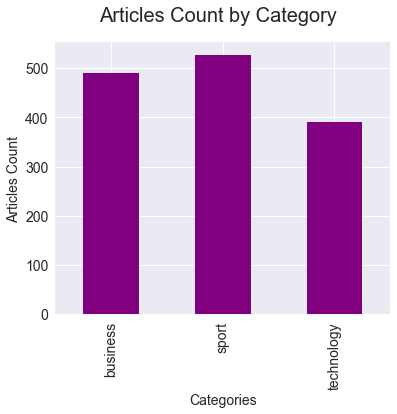

In [60]:
fig_categories = df.groupby('category').name.count().plot.bar(figsize=(6,5),fontsize=14, color='purple')
fig_categories.set_xlabel("Categories",fontsize=14)
fig_categories.set_ylabel("Articles Count",fontsize=14)

plt.suptitle("Articles Count by Category",fontsize=20)
plt.savefig('graphs/category_count.png',dpi=100, bbox_inches='tight')

This figure shows the count of articles per category. This also illustrates that there is a class imbalance where we do not have equal number of documents for sports, business and technology classes. 
<br>Arranging categories based on number of articles present (from more to less):<br>
*Sports > Business > Technology*

#### <u>Plot 2: Comparing Word Clouds for different categories</u>

Plotting to visualize significant terms based on their frequency of occurence. The dataset used was cleaned already and the clean corpus is used to create wordcloud and hence parameters for stopwords removal is not required. 

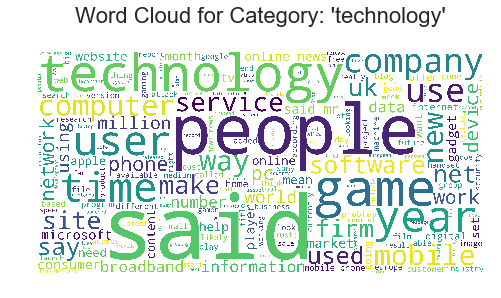

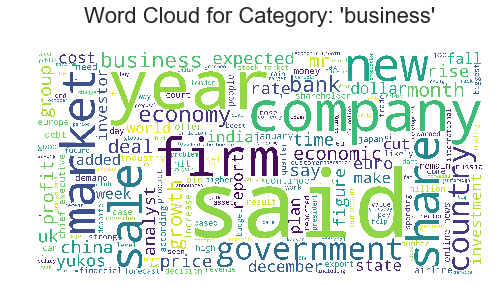

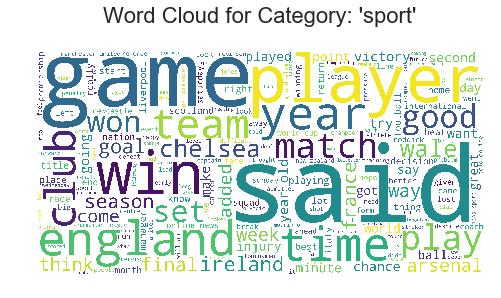

In [61]:
# Create ./graphs for storing plots
os.makedirs(os.getcwd() + "/graphs", exist_ok=True)            

# Word Cloud Category Wise to get most-significant terms
fig = plt.figure()
for i in range(0,len(labels)):
    wordcloud = WordCloud(background_color='white',
                          width=6000,
                          height=3000
                         ).generate(category_concated_documents[i])
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title("Word Cloud for Category: '"+labels[i]+"'\n", fontsize=22)
    plt.savefig("graphs/WordCloud_"+ labels[i] +".png",dpi=100, bbox_inches='tight')
    plt.show()

The images above shows word clouds for the different categories. The most significant terms can be recognized immediatly from wordcloud. The above images have word clouds for the categories: technology, business, sports. 

#### <u>Plot 3: Cosine Similarities for the different categories</u>

Plotting cosine similarity in a heat map for comparing the similarity of the categories.

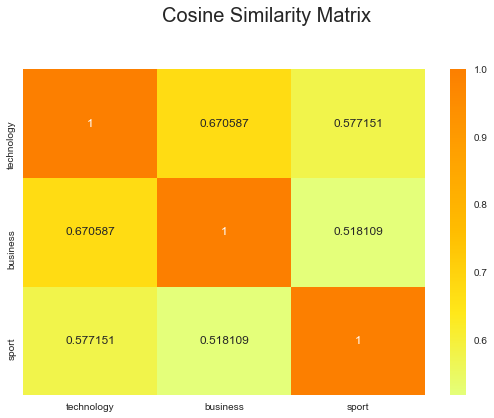

In [62]:
fig_cosine, ax = plt.subplots(figsize=(9,6))
fig_cosine.suptitle("Cosine Similarity Matrix", fontsize=20, verticalalignment='bottom')
sns.heatmap(cosine_matrix, annot=True, fmt="g", cmap=matplotlib.cm.Wistia)
fig_cosine.savefig('graphs/cosine_similarity.png', dpi=100, bbox_inches='tight')
plt.show(fig_cosine)

The plot shows the similarity between the two categories. It can be seen from the heat map that the same categories have a similarity score of 1 and the different categories have different scores.

#### <u>Plot 4: Benchmarking for the two Algorithms</u>

To compare the performace of the classification algorithms used

In [63]:
# Converting accuracies to a dataframe
df_accuracy = pd.DataFrame(columns=["5-fold Cross-Validation Accuracy",
                                    "Accuracy(Default Parameters)", 
                                    "Accuracy(Tuned Parameters)"])
df_accuracy["5-fold Cross-Validation Accuracy"] = cross_validation_accuracy
df_accuracy["Accuracy(Default Parameters)"] = accuracy_scores
df_accuracy["Accuracy(Tuned Parameters)"] = tuned_accuracy_scores
df_accuracy["Model"] = model_names
df_accuracy.set_index("Model", inplace=True)
display(df_accuracy)

,5-fold Cross-Validation Accuracy,Accuracy(Default Parameters),Accuracy(Tuned Parameters)
Model,,,
MultinomialNB,0.979405,0.978723,0.978723
LinearSVC,0.977981,0.981087,0.976359


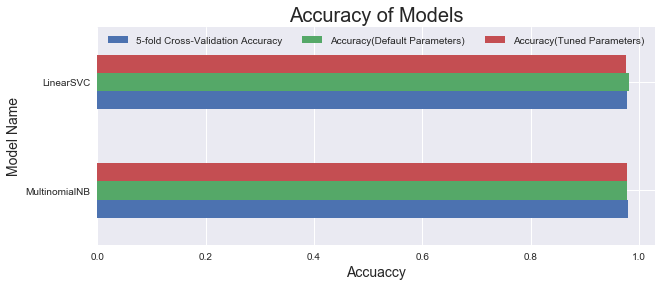

In [64]:
# Plotting Accuracies for two models
axes = df_accuracy.plot.barh(figsize=(10,4))
axes.set_xlabel("Accuaccy",fontsize=14)
axes.set_ylabel("Model Name",fontsize=14)
axes.set_title("Accuracy of Models",fontsize=20)
axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.savefig('graphs/accuracy.png',dpi=100, bbox_inches='tight')


The graph ilustrates a comparison between overall accuracy of the two models alongwith the cross-validation accuracy. This can help to understand how the models behave if only 

#### <u>Plot 5: Execution Times Comparison</u>

Compare the time taken to train and test the models

In [65]:
indices = np.arange(len(models))

training_time = np.array(train_times) / np.max(train_times)
testing_time = np.array(test_times) / np.max(test_times)

tuned_training_time = np.array(tuned_train_times) / np.max(tuned_train_times)
tuned_testing_time = np.array(tuned_test_times) / np.max(tuned_test_times)

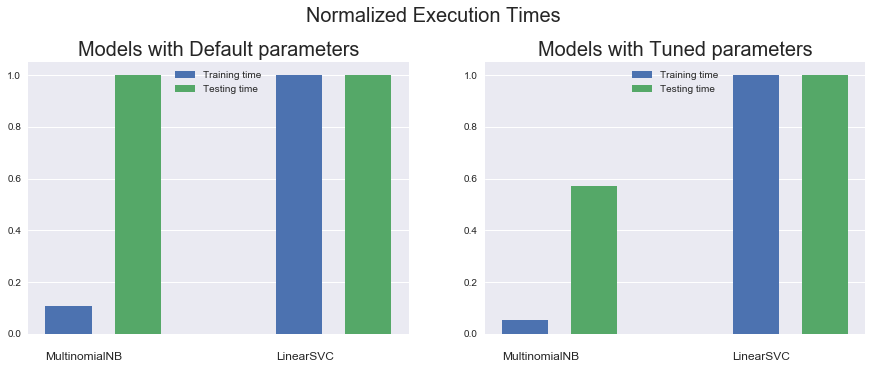

In [66]:
fig_times, ax = plt.subplots(1,2)
fig_times.suptitle("Normalized Execution Times", fontsize=20, verticalalignment='bottom')

ax[0].figure.set_size_inches(15, 5)
ax[0].set_title("Models with Default parameters", fontsize=20)
ax[0].bar(indices + .3, training_time, .2, label="Training time")
ax[0].bar(indices + .6, testing_time, .2, label="Testing time")
ax[0].set_xticks(())
ax[0].legend(loc='upper center')

ax[1].figure.set_size_inches(15, 5)
ax[1].set_title("Models with Tuned parameters", fontsize=20)
ax[1].bar(indices + .3, tuned_training_time, .2, label="Training time")
ax[1].bar(indices + .6, tuned_testing_time, .2, label="Testing time")
ax[1].set_xticks(())
ax[1].legend(loc='upper center')

for i, c in zip(indices, model_names):
    ax[0].text(i+0.2,-.1, c)
    ax[1].text(i+0.2,-.1, c)
fig_times.savefig('graphs/execution_times.png', dpi=100, bbox_inches='tight')
plt.show(fig_times)

Comparison between the execution times for the different algorithms. Comparing Training time to the test time. 

#### <u>Plot 6: Heat Map for Confusion Matrix</u>

Confusion Matrices comparison for the different algorithms used

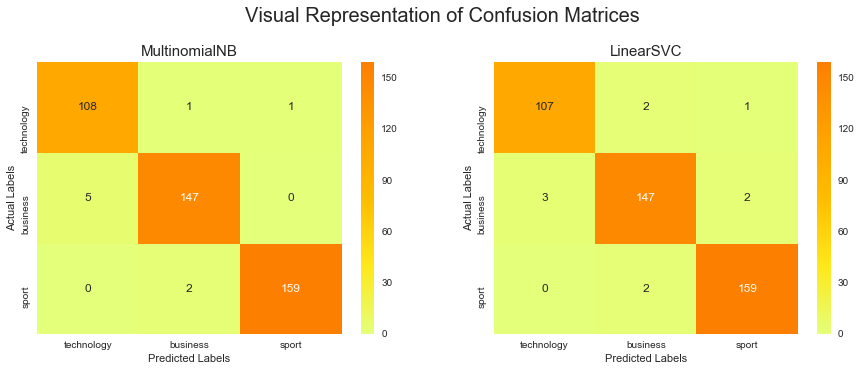

In [67]:
fig_heatMap, ax = plt.subplots(1,len(model_names))
fig_heatMap.suptitle("Visual Representation of Confusion Matrices", fontsize=20, verticalalignment='bottom')
for m in range(0,len(model_names)):
    sns.heatmap(cm[m], annot=True, fmt="g", cmap=matplotlib.cm.Wistia, ax=ax[m])
    ax[m].figure.set_size_inches(15, 5)
    ax[m].set_title(model_names[m], fontsize=15)
fig_heatMap.savefig('graphs/confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show(fig_heatMap)

The image illustrated the confusion matrix for the two classification algorithm. The high concentration on diagonals represent efficienct algorithms as they produced high number of True-Positives.

#### <u>Plot 7: Comparison for Precision, Recall and F1-Measure for the two algorithms</u>

In [68]:
def get_measures(measure):
    '''
    Function to get a dataframe for the requested measure for comparative study between different models
    '''
    cr = pd.DataFrame()
    for m in range(0,len(model_names)):
        cr = cr.append(classification_reports[m][measure], ignore_index=True)
    cr["Model"] = model_names
    cr.set_index("Model", inplace=True)
    return cr.T

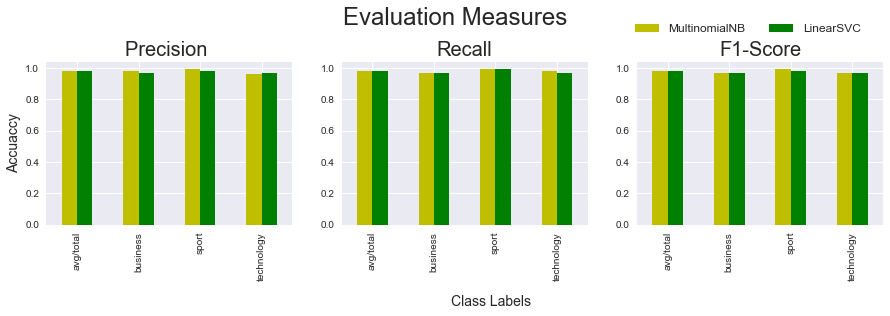

In [69]:
fig_measures, ax6 = plt.subplots(1,3)
get_measures("precision").plot.bar(ax=ax6[0], legend=False,figsize=(15,3), color=['y','g'])
get_measures("recall").plot.bar(ax=ax6[1], legend=False, color=['y','g'])
get_measures("f1-score").plot.bar(ax=ax6[2], legend=False, color=['y','g'])

ax6[0].set_title("Precision ",fontsize=20)
ax6[1].set_title("Recall",fontsize=20)
ax6[2].set_title("F1-Score",fontsize=20)

ax6[0].set_ylabel("Accuaccy",fontsize=14)
ax6[2].legend(loc='upper center', bbox_to_anchor=(0.45, 1.30), ncol=2, fontsize=12)
fig_measures.text(0.5, -0.25, 'Class Labels', fontsize=14)
fig_measures.text(0.40, 1.05, 'Evaluation Measures', fontsize=24)
plt.savefig('graphs/evaluation_measures.png',dpi=100, bbox_inches='tight')
plt.show(fig_measures)

The graph shows the comparision between different Evaluation Measures for better comparison between them.

## <font color="red">Interpretations and Conclusions</font>

### Inferences and Interpretations

<b>Plot 1: Corpus Summary - Category wise articles count</b><br>
* The articles that belong to the different categories are not equals and the classes are imbalanced. 
* Algorithms could be biased towards the class which is having more records, for example sports category has the maximum number of articles and technology category has minimum number of articles. 

<b>Plot 2: Word Cloud </b><br>
* The words in the word clouds depict the documents related to a category has words related to that field. 
* Similary, the other word clouds also show the words that representing those categories which shows we can use the words in the corpus to classify new incoming documents into the available categories. 
<br><br>For example: most occuring words in 'Sports' category are: game, player, time, win. 

<b>Plot 3: Cosine Similarity</b><br>
* From the graphs it can be inferred that the categorical data that we have is dissimilar. Hence, classification models should work well on this data set. 
* Sports category is most un-related to the other categories probably because sports category has more number of articles and can be distinguished well as compared to other categories. 
* Technology and business are also not very similar with a similarity score of 0.67

<b>Plot 4: Comparison of Accuracies of the models</b><br>
* The two models used are Multinomial Naive Bayes and LinearSVC from SVM module. Both the models are highly accurate for the classifying test data. 
* Not only Overall accuracy for both the models are high, the 5-fold cross validation accuracies are very high. 
* After tuning the models, the accuracy for LinearSVC reduced. It is possible that simple model was overfitting due to class imbalance. But the improvement is quite marginal.
* Both the models have 5-fold cross validation accuracies close to (97.80 ± 0.1 %).
* There is no clear winner in terms of accuracy for the two algorithms because for each iteration, their accuracies fluctuates but still they both perform in the similar range of ( 98 ± 0.5 % )

<b>Plot 5: Comparison of Execution Times of the models</b><br>
* The two models used are Multinomial Naive Bayes and LinearSVC from SVM module. As we saw earlier, both the models are highly accurate but the execution times of the two algorithms differ very much. We are comparing the normalized values of execution times in the graph for better comparison.

##### `1. Models with Default Parameters`
* <u>Training Time:</u><br>
> Training Time for :  *(Multinomial Naive Bayes < LinearSVC clearly)*<br>
The reason behind more time required by LinearSVC is that it involved two steps to train a model. First step was to select features and the second was to build the classification model using Pipeline module from scikit-learn. 
Also the Naive Bayes classifier is a probablistic model and is faster to train.
* <u>Testing Time:</u><br>
> Testing Time for :  *(Multinomial Naive Bayes ~= LinearSVC clearly)*<br>
Both the algorithms took similar time and none of them is a clear winner.

##### `2. Model with Parameter Tuning`
* <u>Training Time:</u><br>
> Training Time for :  *(Multinomial Naive Bayes < LinearSVC clearly)*<br>
Clearly, both the classification algorithm took a lot more time to train as compared to algorithms with default parameters becuase the parameter tuning for the algorithms involved cross-validation which accounts for most of the time. 
Again, Naive Bayes was faster to train being less complex model and just one paramter required to be tuned.
* <u>Testing Time:</u><br>
> Testing Time for :  *(Multinomial Naive Bayes > LinearSVC clearly)*<br>
LinearSVC clearly took a lot more time to classify documents as compared to Multinomial Naive Bayes which shows naive bayes can perfrom faster than LinearSVC after parameter tuning. 


<b>Plot 6: Comparison of Confusion Matrices for the models</b><br>
* The two models used are Multinomial Naive Bayes and LinearSVC from SVM module. The algorithms classified most of the documents correctly. 
* The high concentraton of predictions accross the diagonal shows the classifiers performed really well and none of them is clear winner.
* However, the models were able to identify most of the 'sports' articles correctly. This is related to the Plot 1 which shows maximum number of articles belong to sports categories.

<b>Plot 7: Sub-Plots Comparison of Evaluation Measures</b><br>
* <u>Precision:</u> For Naive Bayes, precison is marginally higher than the Linear SVC algorithm in business and sports. For technology, LinearSVC performed better. However, on an average both the models performed same.  
* <u>Recall:</u> It is almost same for both the algorithms but here Naive Bayes gave a better recall for technology as compared to Linear SVC algorithm. Also, precision is inversely proportional to recall. If precision increases, recall decreases. Hence, higher recall means lower precision. Average recall for both the models is same again.
* <u>F1-Measure:</u> It is the harmonic mean of precision and recall and helps to maintain a balance between precision and recall. Both the algorithms performed equally well.

### Conclusions

* Due to class imbalance, majority class can be helpful in building classification models that gives high prediction accuracy for the majority class. Also, we get an understanding that the classifier should maintain reasonable accuracy for the minority classes as well. This dataset is small and for large dataset under-sampling may be used to avoid such class imbalance.  
* Words are very useful features to categorize data using Supervised Machine Learning. The words that are highly visible in the respective word clouds proves that words represent a category. 
* Low Cosine similarity score means they are dissimilar but in sometimes it fails when context meaning cannot be contained in the bag of words model. However, for our data the models worked very well and the categories are actually dissimilar.
* Multinomial Naive Bayes and LinearSVC are highly accepted algorithms for text classifications. Other algorithms such as Decision Trees, KNN or other algorithms may not perform very well as we have sparse feature matrix (i.e. Bag of Words model).
* Choosing an algorithm can depend on our requirements: 
>    1. If less time is available to spend on training examples then Naive Bayes can be used as Naive Bayes can scale easily due to classification based on probabilistic model. 
>    2. If better accuracy is required, Multinomial Naive Bayes can be used. For our dataset, this difference can be ignored for very small values because dataset does not contain any critical information like medical reports. But in general, SVM can perform really well for text classification as it accepts kernel function ('Linear' in our case)
>    3. If faster implementation is required then Naive Bayes can be chosen because tuning LinearSVC is very difficult on the other hand tuning Naive Bayes is a very easy task. 

## <font color="red">Appendix</font>
#### *Algorithms* chosen for the project are highly recommended algorithms for text classification.<br><br> But both of them have pros and cons which are:

<b>Naive Bayes Algorithm for Text Classification:</b>
- Advantages<sup>[7]</sup>
> - Very Simple and easy to implement
> - Need less training data
> - If the NB conditional independence assumption holds, then it will converge quickly
> - Highly scalable. It scales linearly with the number of predictors and data points (as seen can be trained quickly)
> - Multi-class classification problems can also be solved using Naive Bayes (as in our example)
> - Not sensitive to irrelevant features.

- Disadvantages<sup>[8][9]</sup>
> - Naive Bayes is based on the independence assumptions. The conditional independence assumption states that features are independent of each other given the class.
> - We need to estimate the likelihood value by a frequentist approach for any possible value of a feature. This can result in probabilities going towards 0 or 1, which in turn leads to numerical instabilities and worse results. However, we resolved this by using Lidstone smoothening.

<b>SVM (kernal='Linear') for Text Classification:</b><sup>[10]</sup>
- Advantages
> - Works well with even unstructured and semi structured data like text, Images and trees.
> - Allows to pass the kernel function and an appropriate Kernel function can help to solve any complex problem.
> - It scales relatively well to high dimensional data. (As in out case, high number of features)
> - The risk of overfitting is less in SVM using simple kernel function *'Linear'* for small dataset and universal kernel function *'Radial Basis Function (RBF)'* for complex problems 
- Disadvantages
> - Tuning the parameters/ kernel function can be cumbersome.
> - Long training time is required for larger datasets.

#### References:

1. Slides by Mr. Derek Greene for Module Data Science in Python (University College Dublin)
2. http://pandas.pydata.org/
3. http://scikit-learn.org/stable/modules/feature_extraction.html
4. https://matplotlib.org/
5. https://seaborn.pydata.org/generated/seaborn.heatmap.html
6. http://scikit-learn.org/stable/modules/naive_bayes.html
7. https://www.quora.com/What-are-the-advantages-of-using-a-naive-Bayes-for-classification
8. https://nlp.stanford.edu/IR-book/html/htmledition/properties-of-naive-bayes-1.html
9. https://www.quora.com/What-are-the-disadvantages-of-using-a-naive-bayes-for-classificatio
10. https://statinfer.com/204-6-8-svm-advantages-disadvantages-applications/
11. https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel